In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
df1=pd.read_csv("/content/AQUAIR_1.csv")
df2=pd.read_csv("/content/AQUAIR_2.csv")

In [3]:
df=pd.concat([df1,df2],axis=0)
df.head()

,timestamp(UTC),score,temp,humid,co2,voc,pm25,pm10
0,2024-10-14 12:55:00,86.8,19.0,59.8,688.6,320.4,5.3,6.3
1,2024-10-14 13:00:00,83.0,18.2,60.6,646.7,185.0,8.0,9.0
2,2024-10-14 13:05:00,82.2,17.8,61.4,629.4,123.0,4.0,5.0
3,2024-10-14 13:10:00,76.6,16.8,64.3,568.4,79.4,2.8,3.8
4,2024-10-14 13:15:00,73.6,17.0,65.5,551.2,57.8,13.0,14.2


In [4]:
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())

Dataset Shape: (23856, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 23856 entries, 0 to 7322
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp(UTC)  23856 non-null  object 
 1   score           23856 non-null  float64
 2   temp            23856 non-null  float64
 3   humid           23856 non-null  float64
 4   co2             23856 non-null  float64
 5   voc             23856 non-null  float64
 6   pm25            23856 non-null  float64
 7   pm10            23856 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.6+ MB
None


Missing Values:
timestamp(UTC)    0
score             0
temp              0
humid             0
co2               0
voc               0
pm25              0
pm10              0
dtype: int64

Total missing values: 0


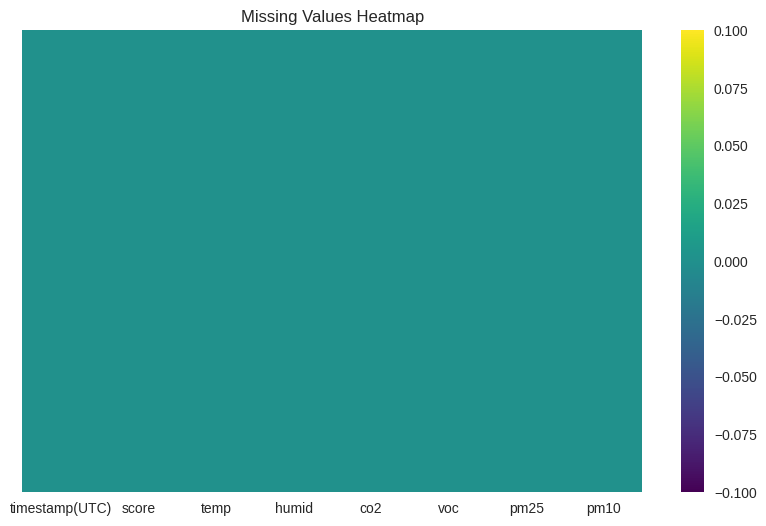

In [5]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [6]:
# Convert timestamp with mixed formats
def convert_timestamp(ts):
    try:
        # Try the first format: YYYY-MM-DD HH:MM:SS
        return pd.to_datetime(ts, format='%Y-%m-%d %H:%M:%S')
    except:
        try:
            # Try the second format: M/D/YYYY HH:MM
            return pd.to_datetime(ts, format='%m/%d/%Y %H:%M')
        except:
            # If both fail, use pandas' flexible parser
            return pd.to_datetime(ts, errors='coerce')

# Apply the conversion
df['timestamp(UTC)'] = df['timestamp(UTC)'].apply(convert_timestamp)

# Check for any failed conversions
failed_conversions = df['timestamp(UTC)'].isnull().sum()
print(f"Failed timestamp conversions: {failed_conversions}")

if failed_conversions > 0:
    print("Rows with failed timestamp conversions:")
    print(df[df['timestamp(UTC)'].isnull()])

    # Remove rows with failed timestamp conversions if any
    df = df.dropna(subset=['timestamp(UTC)'])
    print(f"Removed {failed_conversions} rows with invalid timestamps")

# Extract time-based features
df['hour'] = df['timestamp(UTC)'].dt.hour
df['day'] = df['timestamp(UTC)'].dt.day
df['month'] = df['timestamp(UTC)'].dt.month
df['year'] = df['timestamp(UTC)'].dt.year
df['dayofweek'] = df['timestamp(UTC)'].dt.dayofweek
df['date'] = df['timestamp(UTC)'].dt.date

print("Timestamp conversion completed!")
print(f"Date range: {df['timestamp(UTC)'].min()} to {df['timestamp(UTC)'].max()}")
print(f"New shape: {df.shape}")

Failed timestamp conversions: 0
Timestamp conversion completed!
Date range: 2024-10-14 12:55:00 to 2025-01-09 23:10:00
New shape: (23856, 14)


In [7]:
# Check for duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


In [8]:
# Statistical summary of numerical columns
print("Statistical Summary:")
print(df.describe())

# Separate numerical columns (excluding timestamp)
numerical_cols = ['score', 'temp', 'humid', 'co2', 'voc', 'pm25', 'pm10']

Statistical Summary:
                      timestamp(UTC)         score          temp  \
count                          23856  23856.000000  23856.000000   
mean   2024-11-26 06:34:25.015090432     49.334033     15.949670   
min              2024-10-14 12:55:00      0.000000     11.690000   
25%              2024-11-04 07:13:45     24.400000     15.670000   
50%              2024-11-25 00:12:30     48.000000     16.200000   
75%              2024-12-19 17:11:15     82.800000     16.700000   
max              2025-01-09 23:10:00     92.000000     20.700000   
std                              NaN     28.764298      1.752554   

              humid           co2           voc          pm25          pm10  \
count  23856.000000  23856.000000  23856.000000  23856.000000  23856.000000   
mean      75.792558   1142.508074    468.655728     18.277249     19.580143   
min       48.200000    400.000000     20.000000      0.000000      1.000000   
25%       52.200000    442.600000     64.950000   

In [9]:
# Detect outliers using IQR method
def detect_outliers_iqr(df, columns):
    outlier_info = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_info[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
    return outlier_info

outlier_info = detect_outliers_iqr(df, numerical_cols)
print("Outlier Information:")
for col, info in outlier_info.items():
    print(f"{col}: {info['count']} outliers ({info['percentage']:.2f}%)")

Outlier Information:
score: 0 outliers (0.00%)
temp: 5659 outliers (23.72%)
humid: 0 outliers (0.00%)
co2: 0 outliers (0.00%)
voc: 1060 outliers (4.44%)
pm25: 254 outliers (1.06%)
pm10: 226 outliers (0.95%)


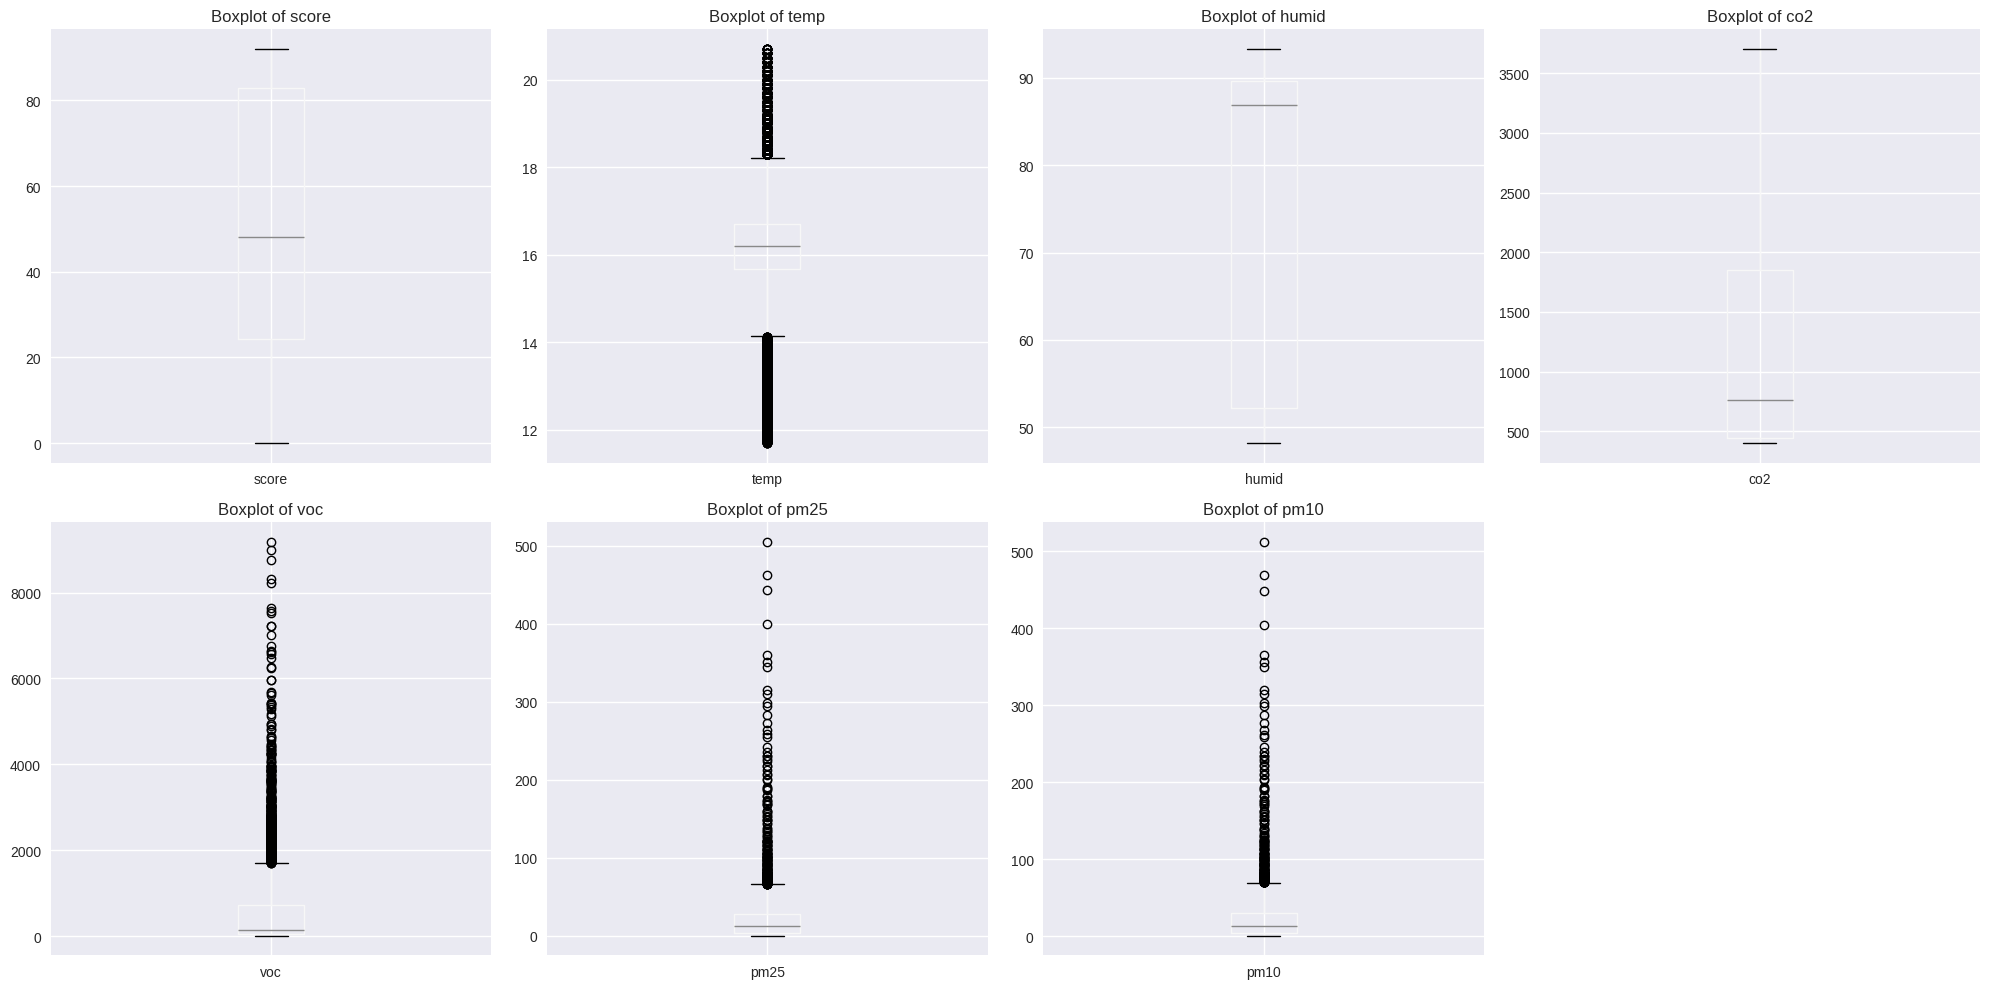

In [10]:
# Box plots for outlier visualization
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Hide empty subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

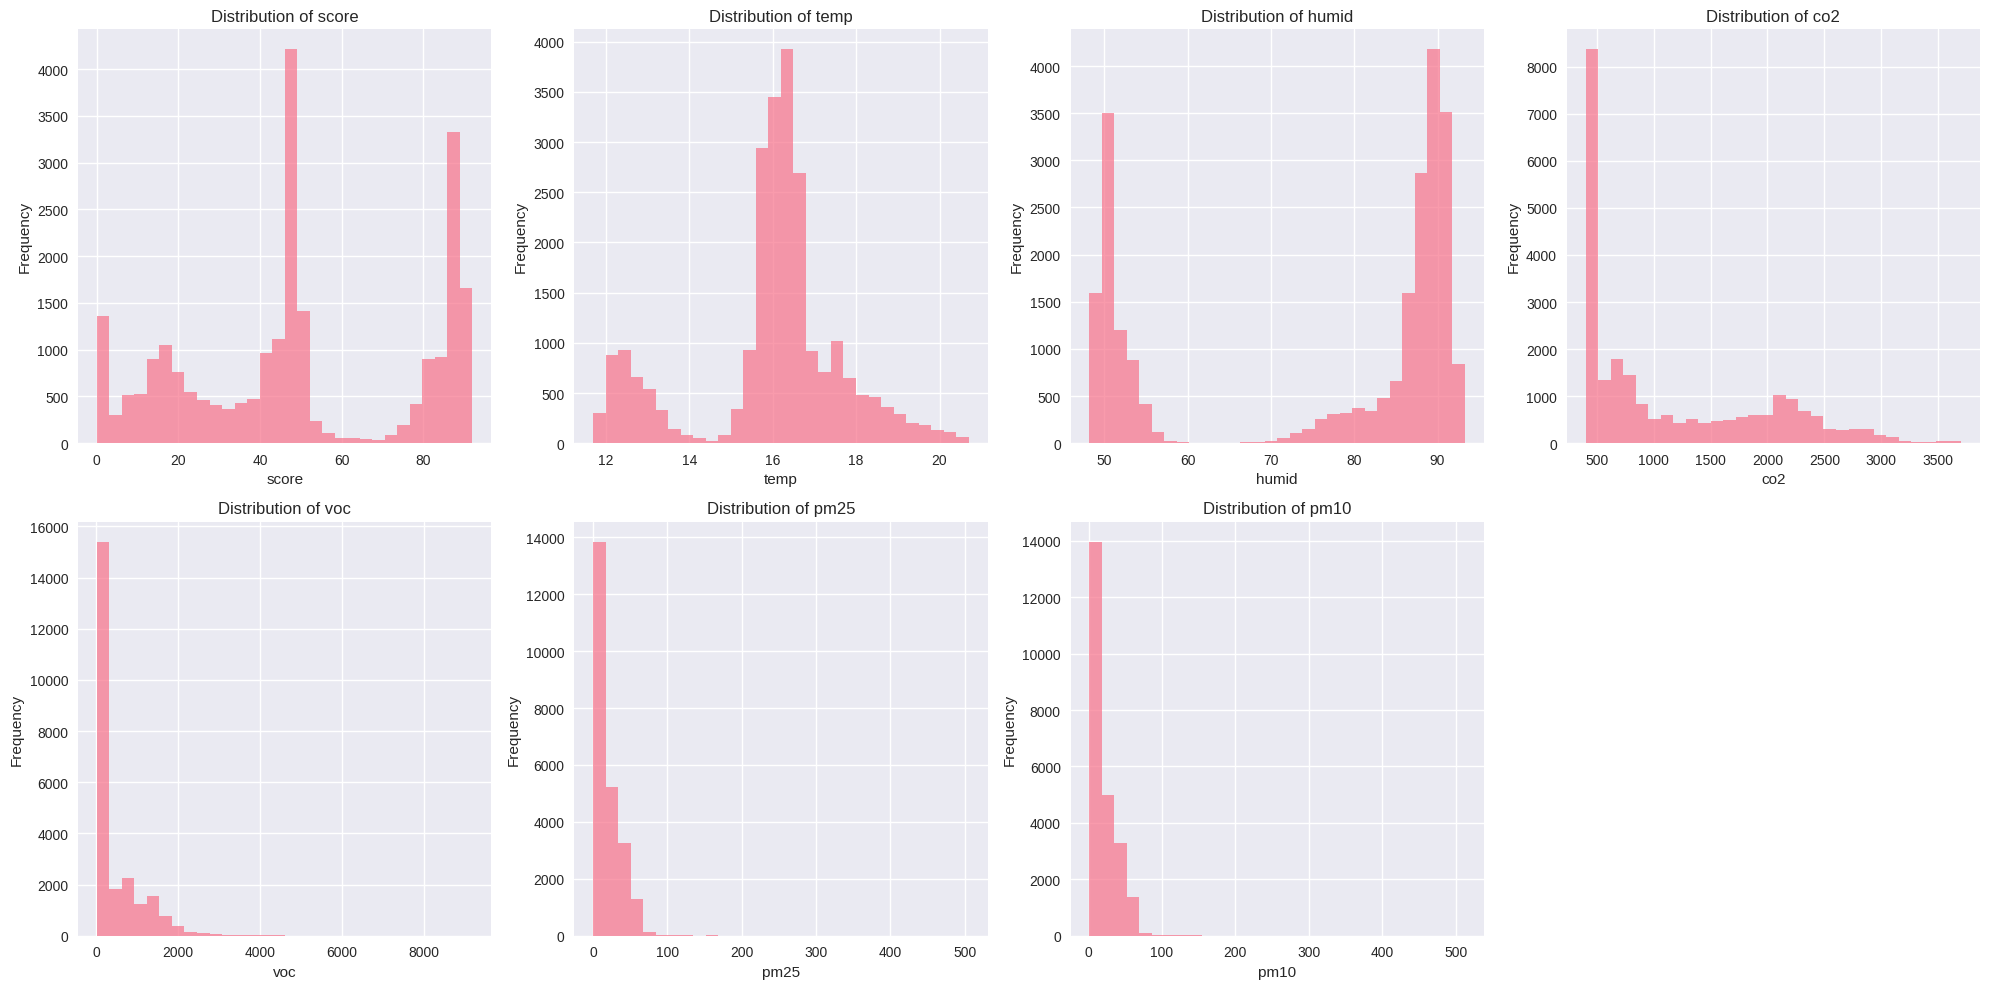

In [11]:
# Distribution of numerical variables
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    df[col].hist(bins=30, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide empty subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

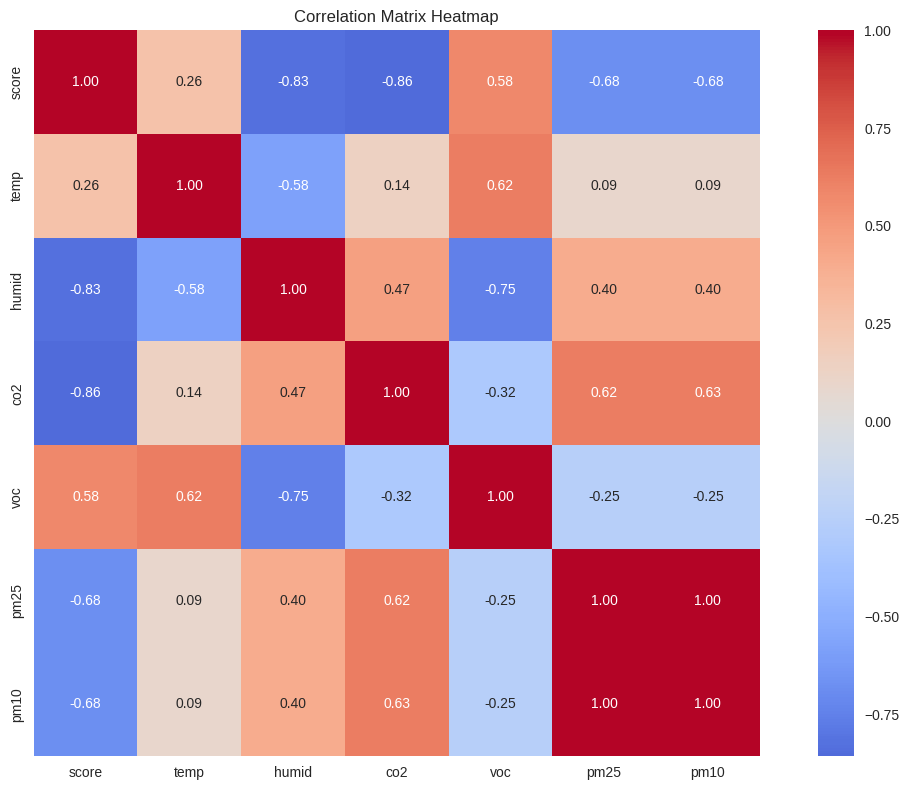

Strong Correlations (|r| > 0.7):
score vs humid: -0.828
score vs co2: -0.857
humid vs voc: -0.750
pm25 vs pm10: 1.000


In [12]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

# Print strong correlations (absolute value > 0.7)
print("Strong Correlations (|r| > 0.7):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            corr_val = correlation_matrix.iloc[i, j]
            print(f"{col1} vs {col2}: {corr_val:.3f}")

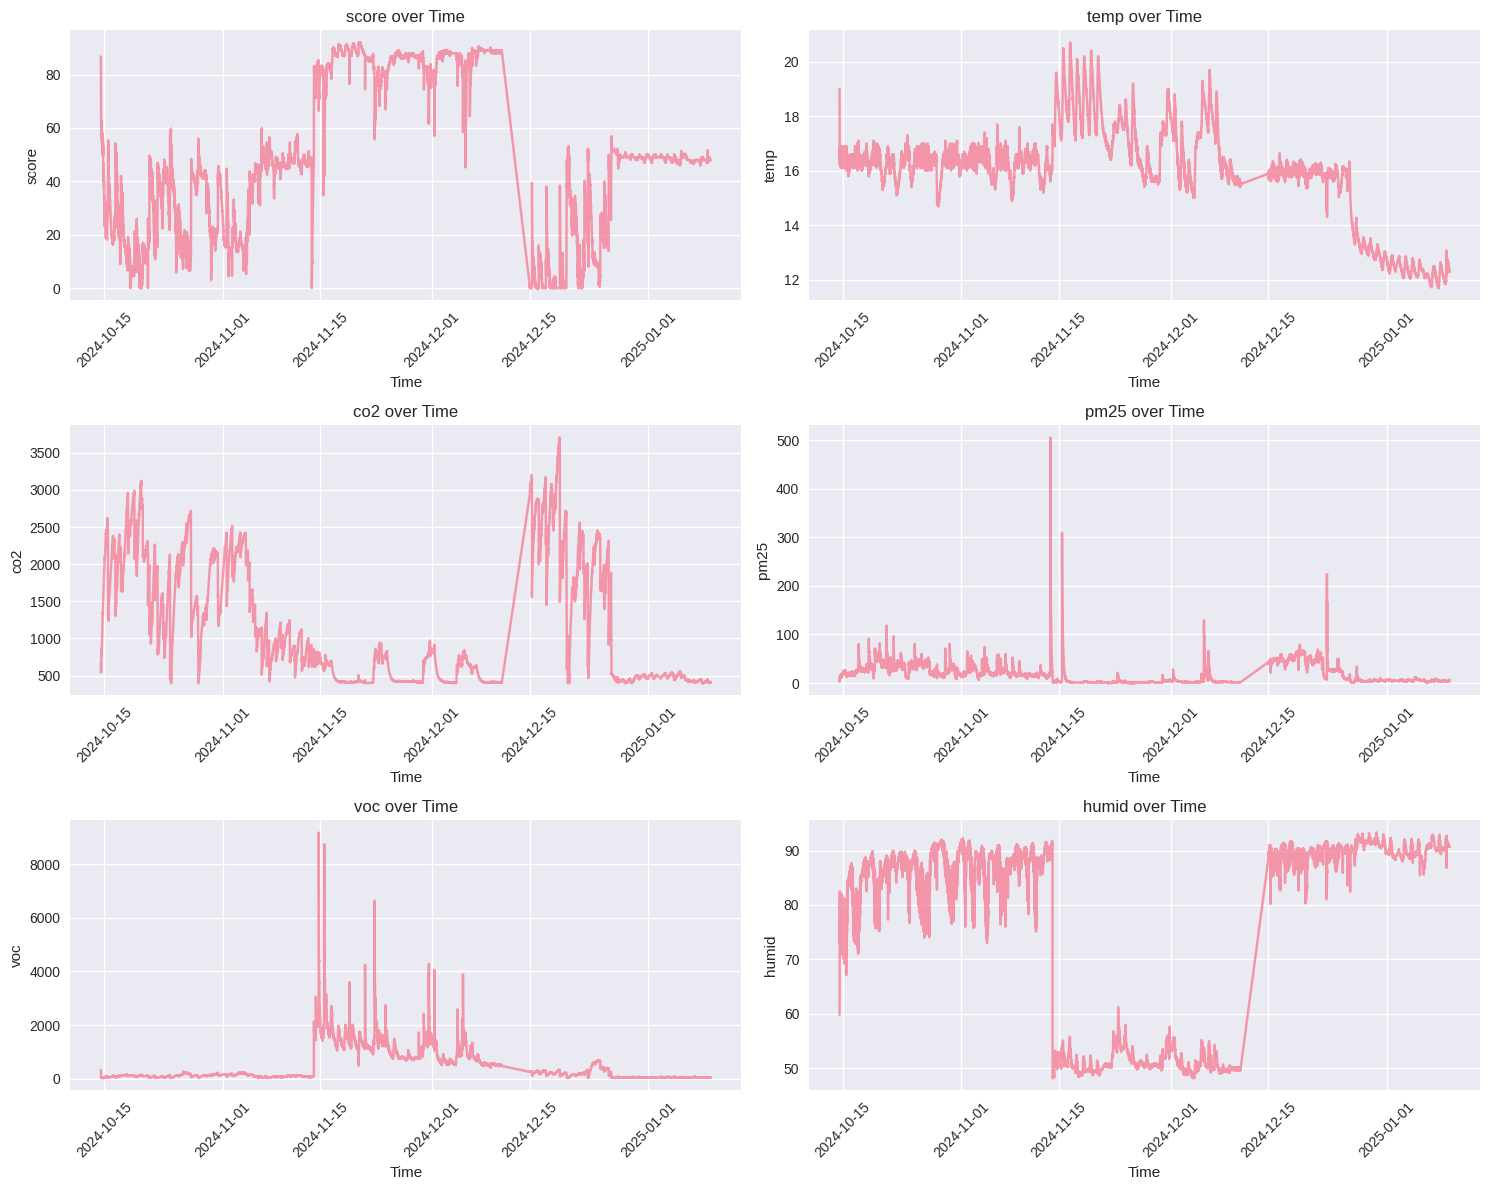

In [13]:
# Plot time series of key variables
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

key_vars = ['score', 'temp', 'co2', 'pm25', 'voc', 'humid']

for i, var in enumerate(key_vars):
    axes[i].plot(df['timestamp(UTC)'], df[var], alpha=0.7)
    axes[i].set_title(f'{var} over Time')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(var)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [14]:
df.head()

,timestamp(UTC),score,temp,humid,co2,voc,pm25,pm10,hour,day,month,year,dayofweek,date
0,2024-10-14 12:55:00,86.8,19.0,59.8,688.6,320.4,5.3,6.3,12,14,10,2024,0,2024-10-14
1,2024-10-14 13:00:00,83.0,18.2,60.6,646.7,185.0,8.0,9.0,13,14,10,2024,0,2024-10-14
2,2024-10-14 13:05:00,82.2,17.8,61.4,629.4,123.0,4.0,5.0,13,14,10,2024,0,2024-10-14
3,2024-10-14 13:10:00,76.6,16.8,64.3,568.4,79.4,2.8,3.8,13,14,10,2024,0,2024-10-14
4,2024-10-14 13:15:00,73.6,17.0,65.5,551.2,57.8,13.0,14.2,13,14,10,2024,0,2024-10-14


In [15]:
df.to_csv("cleaned_aquair_data.csv")